# 07 - Siamese

This notebook goes through how to build a Siamese dataset from scratch.

## What is a Siamese Problem?

Identifying if two images belong to the same class: 

![](https://i.imgur.com/OtRWVFL.png)

Common use cases:

* Person identification
* Small classification sample size

## Why Siamese?

Let's think of an example problem:

> I own 3 dogs and I want to differentiate between the three of them from a photo, but I only have 5 images of each animal.
By our normal standards, we would say that is *far* too little of data for us to work with. But in this case, we have now **120** training samples (not including augmentation).

Our example will use the `PETS` dataset. We won't be training, but if you're dealing with this problem, you should have all the tools you need by now

# Installing the library and *starting* to build the Dataset

In [ ]:
!pip install fastai

In [ ]:
from fastai.vision.all import *

In [ ]:
src = untar_data(URLs.PETS)/'images'

We'll grab all the file names:

In [ ]:
items = get_image_files(src)

And now we can start preparing our dataset. We will be doing everything at the *lowest* level possible today. First let's make a transform that will open some image from a filename and resize it. 

In [ ]:
def resized_image(fn:Path, sz=128):
  "Opens an image from `fn` and resizes it to `sz`"
  x = Image.open(fn).convert('RGB').resize((sz,sz))
  return tensor(array(x)).permute(2,0,1).float()/255.

Now let's get two random images (that we know are different)

In [ ]:
img1 = resized_image(items[0], 448)
img2 = resized_image(items[1], 448)

Now we need some way of viewing our image, along with a title. Let's make a `TitledImage` class:

In [ ]:
class TitledImage(Tuple):
  def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

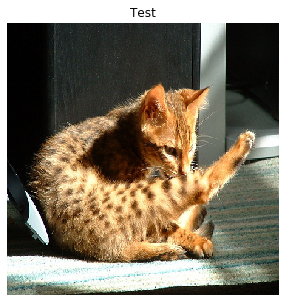

In [ ]:
TitledImage(img1, 'Test').show()

Now let's make something similar for a pair of images (our `Siamese`)

In [ ]:
class SiameseImage(Tuple):
  def show(self, ctx=None, **kwargs):
    im1, im2, is_same = self
    return show_image(torch.cat([im1,im2], dim=2), title=is_same, ctx=ctx, **kwargs)

Let's look at two examples (which look *remarkably*) similar to that image earlier:

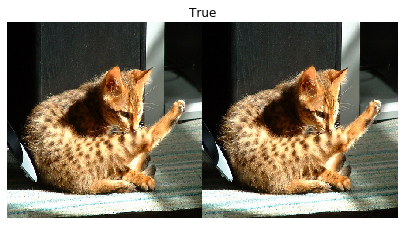

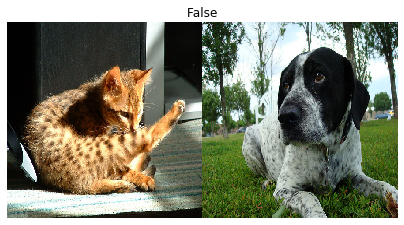

In [ ]:
SiameseImage(img1, img1, True).show(figsize=(7,7));
SiameseImage(img1, img2, False).show(figsize=(7,7));

# SiamesePair

Now we need some transform to generate our `Siamese` dataset. We'll want it to take in a list of items and labels:

In [ ]:
class SiamesePair(Transform):
  "A transform to generate Siamese data"
  def __init__(self, items, labels):
    self.items, self.labels, self.assoc = items,labels,self
    sortlbl = sorted(enumerate(labels), key=itemgetter(1))
    self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
    self.idxs = range_of(self.items)
  
  def encodes(self,i):
    "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
    othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
    otherit = random.choice(othercls)
    same = tensor([self.labels[otherit]==self.labels[i]]).int()
    return SiameseImage(self.items[i], self.items[otherit], same)

We are going to want some labels to be sued, so let's grab some:

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
labels = items.map(labeller)

In [ ]:
labels[:5], len(labels)

((#5) ['Bengal','german_shorthaired','great_pyrenees','japanese_chin','english_setter'],
 7390)

Now we can build our `SiamesePair` transform

In [ ]:
sp = SiamesePair(items, labels)

Let's look at a few bits

In [ ]:
sp.clsmap

{'Abyssinian': (#200) [23,69,89,90,103,127,233,244,288,307...],
 'Bengal': (#200) [0,5,61,77,194,214,234,337,424,457...],
 'Birman': (#200) [16,78,108,158,216,239,321,397,406,482...],
 'Bombay': (#200) [39,41,62,63,84,97,177,187,224,281...],
 'British_Shorthair': (#200) [24,82,92,130,143,156,195,219,283,295...],
 'Egyptian_Mau': (#200) [35,109,183,185,210,259,280,323,355,372...],
 'Maine_Coon': (#200) [44,53,131,135,140,172,246,269,309,333...],
 'Persian': (#200) [99,123,125,126,138,145,168,197,218,223...],
 'Ragdoll': (#200) [50,112,160,240,274,331,351,395,412,450...],
 'Russian_Blue': (#200) [32,68,137,139,141,142,189,250,251,297...],
 'Siamese': (#200) [119,193,322,343,369,370,375,386,552,627...],
 'Sphynx': (#200) [46,75,115,117,174,199,211,231,243,335...],
 'american_bulldog': (#200) [34,59,107,133,169,176,190,241,278,340...],
 'american_pit_bull_terrier': (#200) [17,29,124,191,202,206,235,236,248,285...],
 'basset_hound': (#200) [14,36,149,184,227,255,264,266,276,299...],
 'beagl

In [ ]:
sp.labels

(#7390) ['Bengal','german_shorthaired','great_pyrenees','japanese_chin','english_setter','Bengal','leonberger','english_setter','pomeranian','shiba_inu'...]

Now finally, we can build our `Pipeline`

# Bringing it to a DataLoader

First we'll want to make a `Transform` out of that `resized_image` function we had

In [ ]:
OpenAndResize = Transform(resized_image)

And now that we have all the pieces together, let's build a `Pipeline`:

In [ ]:
pipe = Pipeline([sp, OpenAndResize])

And take a look at it's first set:

In [ ]:
x,y,z = pipe(0)

In [ ]:
x.shape, y.shape, z

(torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 tensor([0], dtype=torch.int32))

To turn anything into a `DataLoader`, we want it to first be a `TfmdList`. We can accomplish this by passing in a list of index's and a `Pipeline` to run through:

In [ ]:
tls = TfmdLists(range_of(items), pipe)

And now make our `Dataloaders`

In [ ]:
dls = tls.dataloaders(bs=16, after_batch=[Normalize.from_stats(*imagenet_stats)])

And we can look at a batch!

In [ ]:
batch = dls.one_batch()

Now I did not get the `show` function working, so let's take a look the very "simple" way

In [ ]:
a,b,c = batch[0][0], batch[1][0], batch[2][0]

In [ ]:
a.shape, b.shape, c

(torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]),
 tensor([1], dtype=torch.int32))

In [ ]:
from torchvision import transforms

In [ ]:
im1 = transforms.ToPILImage()(batch[0][0]).convert("RGB")
im2 = transforms.ToPILImage()(batch[1][0]).convert("RGB")

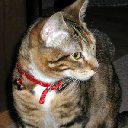

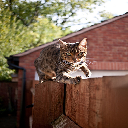

In [ ]:
display(im1, im2)

While we cannot display, you now have a `DataLoader` ready for Siamese networks!